# The realization of a dream: open a Sushi Bar in Bologna

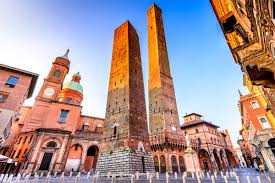

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

An old aunt left a nice nest egg to the undersigned: 3 million euros. I can finally realize my dream: to open a trendy restaurant in one of the most beautiful Italian cities.
I have always worked in the world of catering and I am doing well in the kitchen. To follow my dreams I went to Japan and spent 5 wonderful years learning the secrets of Sushi. Also I love being among young people. So my dream is to open a Sushi Bar in a university city where there are many young people. The choice falls on Bologna, a city full of young people with a historical university. The opening price may be lower than in other cities. There would be competition in any case because Bologna is full of clubs. There are not as many foreign tourists as in Rome or Milan, so opening in Bologna would have this penalty. But the city is sensitive to news and this is a plus.<br/>
Since I am convinced of my skills and the fact that my Sushi bar can offer something better than the competition, I will try to rent the place where there is a greater concentration of restaurants and possibly Sushi Bars.
Obviously I will try to stay as close as possible to the center, compatibly with the cost of the rent. <br/>
I will try to identify areas with the biggest concentation of young people. <br/>

This study will help anyone who wants to start a restaurant business in a young and dynamic city like Bologna
The business plan that will be illustrated has a general value: anyone who wants to open a restaurant somewhere will find the illustrated methodology and the examples provided useful. The considerations made can be applied to any city and to any type of restaurant / pub / caffee shop etc etc.

## Data <a name="data"></a>

The following data sources will be needed to extract/generate the required information:
* A Pandas dataframe will be provided with some data about the main Bologna's neighborhoods (name, density of inhabitants, distance from the University, cost of rent)
* The dataframe will be enriched by the centers of candidate areas that will be generated algorithmically and approximate addresses of centers of those areas will be obtained using Google Maps API reverse geocoding.
* Number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API. Through a Bubble Chart it will be possible to identify the areas with the highest concentration of restaurants.
* The list of Sushi Bars in the Bologna neighbourhoods and their location with respect to the city center will retrieved using Foursquare API.
* For each Sushi Bar I will analyze the number of clicks received and the comments. From these data I will be able to understand the age of the clientele in relation the position of the restaurant itself.

The area where the Sushi Bar will be opened will be chosen according to the following criteria:
    - density of restaurants
    - density of competitor Sushi bars
    - distance from the University
    - density of young population


# Bologna's neighborhoods

Let's retrieve the Bologna's neighborhoods data. Wea regoing to use the 'pd.read_html'. It returns a list of objects containing the info grabbed from the html page.In this  case the Dataframe we are looking for is contained in the first object of the list.

In [44]:
import pandas as pd
import numpy as np

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge folium --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [45]:
url_html='https://it.wikipedia.org/wiki/Quartieri_di_Bologna'
bologna_obj = pd.read_html(url_html)
bologna_df = bologna_obj[0]
bologna_df.head()

,Quartiere,Superficie (km²),Abitanti[2],Densità (ab/km²),Suddivisioni,Presidente
0,Borgo Panigale-Reno,31436,61.141,194494.00000,"Borgo Panigale, Casteldebole, La Birra, Barca,...",Vincenzo Naldi [3] (Partito Democratico)
1,San Donato-San Vitale,26268,66.297,2.52387,"San Donato, San Vitale, San Donnino, Pilastro,...",Simone Borsari [4] (centrosinistra)
2,Navile,25875,69.187,2.67389,"Lame, Corticella, Bolognina",Daniele Ara [4](centrosinistra)
3,Porto-Saragozza,15766,69.477,4.40676,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf...",Lorenzo Cipriani (centrosinistra)
4,Santo Stefano,30040,64.258,2.13908,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi...",Rosa Maria Amorevole [5] (centrosinistra)


Some tuning is required on the dataframe. Let's start dropping unuseful columns.

In [46]:
bologna_df = bologna_df.drop(['Presidente'], axis=1)

Now let's rename the column's name from italian to english

In [47]:
print(bologna_df.columns)
bologna_df.columns = ['neighborhood', 'area', 'inhabitants', 'density', 'sub district']
bologna_df.head()

Index(['Quartiere', 'Superficie (km²)', 'Abitanti[2]', 'Densità (ab/km²)',
       'Suddivisioni'],
      dtype='object')


,neighborhood,area,inhabitants,density,sub district
0,Borgo Panigale-Reno,31436,61.141,194494.00000,"Borgo Panigale, Casteldebole, La Birra, Barca,..."
1,San Donato-San Vitale,26268,66.297,2.52387,"San Donato, San Vitale, San Donnino, Pilastro,..."
2,Navile,25875,69.187,2.67389,"Lame, Corticella, Bolognina"
3,Porto-Saragozza,15766,69.477,4.40676,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf..."
4,Santo Stefano,30040,64.258,2.13908,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi..."


Some more format changes on the numerical data ...

In [48]:
bologna_df['area'] = bologna_df['area']/1000
bologna_df['inhabitants'] = bologna_df['inhabitants'] * 1000
bologna_df['density'] = bologna_df['inhabitants']/bologna_df['area']
bologna_df.head(10)

,neighborhood,area,inhabitants,density,sub district
0,Borgo Panigale-Reno,31.436,61141.0,1944.935742,"Borgo Panigale, Casteldebole, La Birra, Barca,..."
1,San Donato-San Vitale,26.268,66297.0,2523.869347,"San Donato, San Vitale, San Donnino, Pilastro,..."
2,Navile,25.875,69187.0,2673.893720,"Lame, Corticella, Bolognina"
3,Porto-Saragozza,15.766,69477.0,4406.761385,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf..."
4,Santo Stefano,30.040,64258.0,2139.081225,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi..."
5,Savena,11.469,59810.0,5214.927195,"Mazzini, San Ruffillo, Fossolo, Pontevecchio, ..."


In [49]:
bologna_df.describe()

,area,inhabitants,density
count,6.000000,6.000000,6.000000
mean,23.475667,65028.333333,3150.578102
std,8.045002,4040.555292,1336.878821
min,11.469000,59810.000000,1944.935742
25%,18.293250,61920.250000,2235.278255
50%,26.071500,65277.500000,2598.881533
75%,29.097000,68464.500000,3973.544469
max,31.436000,69477.000000,5214.927195


Let's try to have a graphical representation of the density.

In [50]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

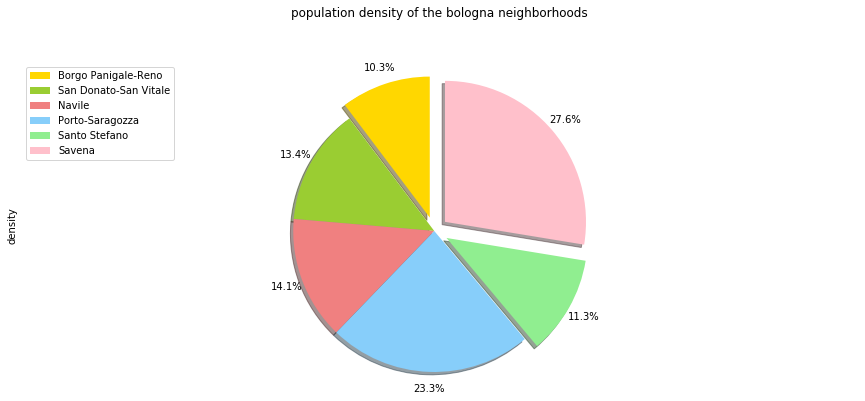

In [51]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0, 0, 0, 0.1, 0.1] # ratio for each continent with which to offset each wedge.
bologna_df['density'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('population density of the bologna neighborhoods', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=bologna_df['neighborhood'], loc='upper left') 

plt.show()

From this first analysis we realize that there are a couple of neighborhoods more crowded than the other. They are 'Savena' and 'Porto Saragozza'. So we can guess that those neighboorhood are in the downtown. We have to keep in mind this information in the future.<br/>
Let's try to retrieve the latitude and longitude of every neighborhood. This data will be added to the current dataframe.

In [52]:
geolocator = Nominatim(user_agent="bo_explorer")
longitude = []
latitude = []
for neigh in bologna_df['neighborhood']:
    address = neigh + ', Bologna, Italy'
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    #print('The geograpical coordinate of {} are {}, {}.'.format(neigh, location.latitude, location.longitude))
#print(latitude)
#print(longitude)
bologna_df['latitude'] = latitude
bologna_df['longitude'] = longitude
bologna_df.head()

,neighborhood,area,inhabitants,density,sub district,latitude,longitude
0,Borgo Panigale-Reno,31.436,61141.0,1944.935742,"Borgo Panigale, Casteldebole, La Birra, Barca,...",44.521942,11.271077
1,San Donato-San Vitale,26.268,66297.0,2523.869347,"San Donato, San Vitale, San Donnino, Pilastro,...",44.511899,11.395177
2,Navile,25.875,69187.0,2673.893720,"Lame, Corticella, Bolognina",44.518470,11.328901
3,Porto-Saragozza,15.766,69477.0,4406.761385,"Andrea Costa-Saragozza, Malpighi, Marconi, Saf...",44.477876,11.304899
4,Santo Stefano,30.040,64258.0,2139.081225,"Galvani, Irnerio, Murri, Colli, Roncrio, Barbi...",44.492055,11.349035


Save the dataframe as a csv file.

In [53]:
bologna_df.to_csv(r'bologna-neigh.csv', index=False)

Why not plot a choropleth picture of the Bologna's neighborhoods? We need a geojson file. I have prepared one.

In [93]:
#  read the geojson file
bologna_geo = r'bologna.geojson' # geojson file
# create a plain bologna map
bologna_address = 'Bologna, Italy'
location = geolocator.geocode(bologna_address)
bo_latitude = location.latitude
bo_longitude = location.longitude
print('The geograpical coordinate of Bologna are {}, {}.'.format(bo_latitude, bo_longitude))

The geograpical coordinate of Bologna are 44.4936714, 11.3430347.


In [94]:
bologna_map = folium.Map(location=[bo_latitude, bo_longitude], zoom_start=11)
bologna_map

And now to create a `Choropleth` map, we will use the *choropleth* method with the following main parameters:

1. geo_data, which is the GeoJSON file.
2. data, which is the dataframe containing the data.
3. columns, which represents the columns in the dataframe that will be used to create the `Choropleth` map.
4. key_on, which is the key or variable in the GeoJSON file that contains the name of the variable of interest. To determine that, you will need to open the GeoJSON file using any text editor and note the name of the key or variable that contains the name of the neighborhoods, since the neighborhoods are our variable of interest. In this case, **name** is the key in the GeoJSON file that contains the name of the neighborhoods. Note that this key is case_sensitive, so you need to pass exactly as it exists in the GeoJSON file.

In [95]:
# generate choropleth map using the density of population of the Bologna's neighborhoods
bologna_map.choropleth(
    geo_data=bologna_geo,
    data=bologna_df,
    columns=['neighborhood', 'density'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Bologna neighborhoods density'
)

# display map
bologna_map

Here we go. The Pandas Dataframe has been cleaned and now we can move further and add some more interesting informations to it.

## Define Foursquare Credentials and Version

In [89]:
CLIENT_ID = 'WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI' # your Foursquare ID
CLIENT_SECRET = 'NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI
CLIENT_SECRET:NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL


Create a map of Bologna with neighborhoods superimposed on top

In [98]:
# create map of New York using latitude and longitude values
map_bologna = folium.Map(location=[bo_latitude, bo_longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(bologna_df['latitude'], bologna_df['longitude'], bologna_df['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bologna)  
    
map_bologna

### Let's explore the University of Bologna neighborhood in our dataframe.

First let' get the coohordinates of the University. This info will be helpful later.

In [97]:
university_address = 'Via Zamboni 33, Bologna, Italy'
location = geolocator.geocode(university_address)
university_latitude = location.latitude
university_longitude = location.longitude
print('The geograpical coordinate of Bologna University are {}, {}.'.format(university_latitude, university_longitude))

The geograpical coordinate of Bologna University are 44.4971104, 11.352995.


#### Now, let's get the top 100 venues that are in the Bologna university neighborhoods within a radius of 500 meters.
#### https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&radius=RADIUS&limit=LIMIT

First, let's create the GET request URL. Name your URL url.

In [102]:
# type your answer here
radius = 500
VERSION = '20180604'
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, university_latitude, university_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=WWBTWNSZFP50UEEBGV00MGOCHXEY1ORQWQLRNO0KLYZURLQI&client_secret=NFQAIQUXJ0UYTEMS3USDDMQRCFJITUFG3N2KBPC43D3UTHBL&ll=44.4971104,11.352995&v=20180604&radius=500&limit=100'

Send the GET request and examine the resutls

In [103]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e9fc667aba297001b11b00b'},
 'response': {'headerLocation': 'Università di Bologna',
  'headerFullLocation': 'Università di Bologna, Bologna',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 38,
  'suggestedBounds': {'ne': {'lat': 44.5016104045, 'lng': 11.359292058618216},
   'sw': {'lat': 44.492610395499995, 'lng': 11.346697941381784}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51eba116498e1f30b2c435f6',
       'name': 'Museo Di Palazzo Poggi',
       'location': {'lat': 44.49691099187413,
        'lng': 11.352514220250136,
        'labeledLatLngs': [{'label': 'display',
          'lat': 44.49691099187413,
          'lng': 11.352514220250136}],
        'distance': 44,
        'cc': 'IT',
        'country': 'Ita

It seems that the area aroud the University is really full of restaurants and bars.

We now that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [105]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [136]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(40)

,name,categories,lat,lng
0,Museo Di Palazzo Poggi,Science Museum,44.496911,11.352514
1,Hamerica's,Burger Joint,44.497246,11.353017
2,Accademia delle Belle Arti,College Arts Building,44.498358,11.352895
3,Teatro Comunale,Opera House,44.496524,11.349929
4,Orto Botanico,Garden,44.499682,11.352944
5,Cento3cento Veg,Vegetarian / Vegan Restaurant,44.498655,11.350813
6,Moustache,Cocktail Bar,44.498138,11.349275
7,Caffetteria Al Salam,Mediterranean Restaurant,44.498798,11.350818
8,Baracca e Burattini,Café,44.499493,11.351194
9,Dopa Hostel,Hostel,44.499425,11.351310


In [137]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

38 venues were returned by Foursquare.


## 2. Explore Neighborhoods in Bologna

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [138]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *bologna_venues*.

In [139]:
bologna_venues = getNearbyVenues(names=bologna_df['neighborhood'],
                                   latitudes=bologna_df['latitude'],
                                   longitudes=bologna_df['longitude']
                                  )

Borgo Panigale-Reno
San Donato-San Vitale
Navile
Porto-Saragozza
Santo Stefano
Savena


#### Let's check the size of the resulting dataframe

In [140]:
print(bologna_venues.shape)
bologna_venues.head(50)

(104, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Borgo Panigale-Reno,44.521942,11.271077,Trattoria della Salute,44.524890,11.274950,Restaurant
1,Borgo Panigale-Reno,44.521942,11.271077,Hostaria dei 4 Gatti,44.518868,11.270852,Pub
2,Borgo Panigale-Reno,44.521942,11.271077,Hotel del Borgo,44.520342,11.266867,Hotel
3,Borgo Panigale-Reno,44.521942,11.271077,Piscina Cavina,44.522394,11.269097,Pool
4,Borgo Panigale-Reno,44.521942,11.271077,Sogese,44.522846,11.269198,Gym Pool
5,Borgo Panigale-Reno,44.521942,11.271077,Wally,44.523450,11.269383,Ice Cream Shop
6,Borgo Panigale-Reno,44.521942,11.271077,Ristorante Il Desiderio,44.520100,11.267480,Italian Restaurant
7,San Donato-San Vitale,44.511899,11.395177,Fashion & Fitness,44.514837,11.398441,Gym / Fitness Center
8,San Donato-San Vitale,44.511899,11.395177,Decathlon,44.514996,11.397420,Sporting Goods Shop
9,San Donato-San Vitale,44.511899,11.395177,CASA,44.514818,11.398246,Furniture / Home Store


Let's check how many venues were returned for each neighborhood

In [141]:
bologna_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Borgo Panigale-Reno,7,7,7,7,7,7
Navile,18,18,18,18,18,18
Porto-Saragozza,5,5,5,5,5,5
San Donato-San Vitale,17,17,17,17,17,17
Santo Stefano,50,50,50,50,50,50
Savena,7,7,7,7,7,7


The 'Santo Stefano' neighborhood is the most crowded for sure! I guess that this is the most interesting area where opening my Sushi Bar.

#### Let's find out how many unique categories can be curated from all the returned venues

In [142]:
print('There are {} uniques categories.'.format(len(bologna_venues['Venue Category'].unique())))

There are 54 uniques categories.


## Analyze Each Neighborhood

In [147]:
# one hot encoding
bologna_onehot = pd.get_dummies(bologna_venues[['Venue Category']], prefix="", prefix_sep="")

# get neighborhood column to a temporary dataframe
bologna_onehot['Neighborhood'] = bologna_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [bologna_onehot.columns[-1]] + list(bologna_onehot.columns[:-1])
bologna_onehot = bologna_onehot[fixed_columns]

Let's take a look at the dataframe's size

In [149]:
bologna_onehot.shape

(104, 55)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [151]:
bologna_onehot_grouped = bologna_onehot.groupby('Neighborhood').mean().reset_index()
bologna_onehot_grouped

,Neighborhood,Asian Restaurant,Bakery,Bar,Bistro,Bookstore,Brewery,Butcher,Café,Candy Store,...,Sandwich Place,Scenic Lookout,Shopping Mall,Skate Park,Soccer Stadium,Sporting Goods Shop,Supermarket,Theater,Vegetarian / Vegan Restaurant,Wine Bar
0,Borgo Panigale-Reno,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
1,Navile,0.055556,0.00,0.000000,0.00,0.055556,0.00,0.00,0.111111,0.055556,...,0.000000,0.00,0.055556,0.055556,0.055556,0.000000,0.000000,0.000000,0.00,0.00
2,Porto-Saragozza,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,...,0.000000,0.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
3,San Donato-San Vitale,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.058824,0.000000,...,0.058824,0.00,0.058824,0.000000,0.000000,0.058824,0.000000,0.058824,0.00,0.00
4,Santo Stefano,0.000000,0.04,0.040000,0.04,0.000000,0.02,0.02,0.040000,0.000000,...,0.060000,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.02,0.06
5,Savena,0.000000,0.00,0.142857,0.00,0.000000,0.00,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.00,0.00


#### Let's confirm the new size

In [152]:
bologna_onehot_grouped.shape

(6, 55)

#### Let's print each neighborhood along with the top 5 most common venues

In [154]:
num_top_venues = 5

for hood in bologna_onehot_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bologna_onehot_grouped[bologna_onehot_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Borgo Panigale-Reno----
                venue  freq
0            Gym Pool  0.14
1          Restaurant  0.14
2               Hotel  0.14
3      Ice Cream Shop  0.14
4  Italian Restaurant  0.14


----Navile----
                venue  freq
0                Café  0.11
1    Asian Restaurant  0.06
2       Shopping Mall  0.06
3  Italian Restaurant  0.06
4   Mobile Phone Shop  0.06


----Porto-Saragozza----
               venue  freq
0     Scenic Lookout   0.4
1  Food & Drink Shop   0.2
2               Park   0.2
3      Historic Site   0.2
4   Asian Restaurant   0.0


----San Donato-San Vitale----
                    venue  freq
0  Furniture / Home Store  0.12
1          Clothing Store  0.12
2        Department Store  0.06
3             Pizza Place  0.06
4                    Pool  0.06


----Santo Stefano----
                venue  freq
0  Italian Restaurant  0.18
1               Plaza  0.12
2      Ice Cream Shop  0.08
3      Sandwich Place  0.06
4            Wine Bar  0.06


----Savena---

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [155]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [157]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bologna_onehot_grouped['Neighborhood']

for ind in np.arange(bologna_onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bologna_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Borgo Panigale-Reno,Gym Pool,Hotel,Ice Cream Shop,Italian Restaurant,Restaurant,Pub,Pool,Wine Bar,Cosmetics Shop,...,Fish Market,Fast Food Restaurant,Emilia Restaurant,Electronics Store,Department Store,Cupcake Shop,Clothing Store,College Library,Furniture / Home Store,Chinese Restaurant
1,Navile,Café,Asian Restaurant,Candy Store,Gastropub,Department Store,Ice Cream Shop,Cosmetics Shop,Italian Restaurant,Mobile Phone Shop,...,Performing Arts Venue,Pizza Place,Park,Soccer Stadium,Bookstore,Shopping Mall,Skate Park,Cupcake Shop,Bakery,Fish Market
2,Porto-Saragozza,Scenic Lookout,Historic Site,Food & Drink Shop,Park,Wine Bar,Cosmetics Shop,Furniture / Home Store,Food Stand,Fish Market,...,Emilia Restaurant,Electronics Store,Department Store,Cupcake Shop,College Library,Grocery Store,Clothing Store,Chinese Restaurant,Cheese Shop,Candy Store
3,San Donato-San Vitale,Clothing Store,Furniture / Home Store,Sandwich Place,Music Venue,Park,Pizza Place,Café,Pool,Department Store,...,Shopping Mall,Fast Food Restaurant,Sporting Goods Shop,Theater,Electronics Store,College Library,Emilia Restaurant,Fish Market,Food & Drink Shop,Cupcake Shop
4,Santo Stefano,Italian Restaurant,Plaza,Ice Cream Shop,Wine Bar,Sandwich Place,Bakery,Bar,Bistro,Café,...,Cupcake Shop,College Library,Multiplex,Vegetarian / Vegan Restaurant,Grocery Store,Emilia Restaurant,Monument / Landmark,Cheese Shop,Chinese Restaurant,Fish Market
